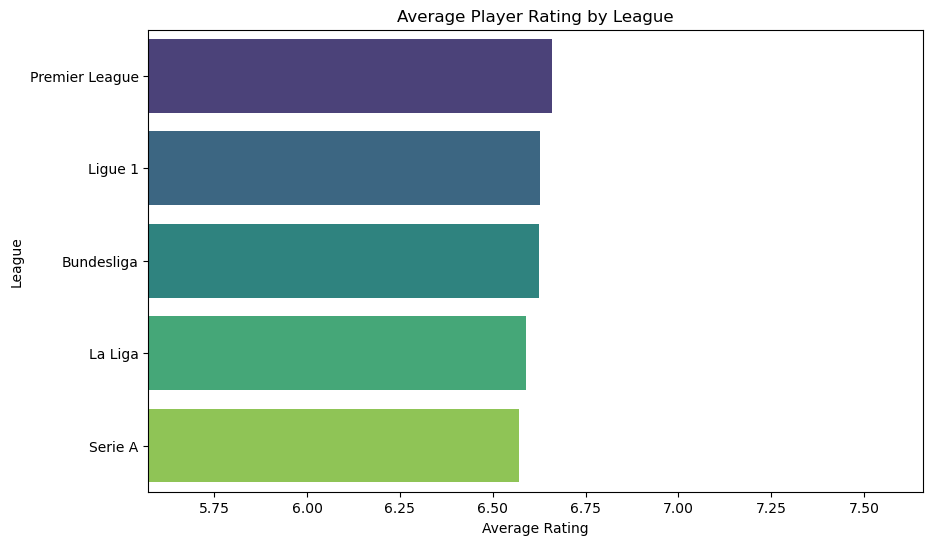

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("./Data/finalized_players.csv")

# Group by league and calculate the mean rating
league_avg_rating = df.groupby("League")["Rating"].mean().reset_index()

# Sort by rating for better visualization
league_avg_rating = league_avg_rating.sort_values(by="Rating", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=league_avg_rating, x="Rating", y="League", palette="viridis")

# Labels and title
plt.xlabel("Average Rating")
plt.ylabel("League")
plt.title("Average Player Rating by League")
plt.xlim(league_avg_rating["Rating"].min() - 1, league_avg_rating["Rating"].max() + 1)

# Show plot
plt.show()


In [2]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("./Data/finalized_players.csv")
df = df.drop(columns=['Player Name'])  # Remove identifier column

# One-hot encode categorical columns
categorical_cols = ['Pos', 'Squad', 'League', 'Season']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Fill missing values
df = df.fillna(df.median())

# Drop Season columns if needed
df = df.drop(df.filter(like="Season").columns, axis=1)
df = df.drop(df.filter(like="Squad").columns, axis=1)
df = df.drop(df.filter(like="League").columns, axis=1)

# Split data into features (X) and target (y)
X = df.drop(columns=['Rating'])
y = df['Rating']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define Optuna objective function
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    # Train model
    model = xgb.XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train)

    # Validate performance
    y_pred = model.predict(X_val)
    return r2_score(y_val, y_pred)

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

# Print best parameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train final model with best parameters
best_model = xgb.XGBRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Evaluate performance on test set
y_pred_test = best_model.predict(X_test)
final_r2 = r2_score(y_test, y_pred_test)
final_mae = mean_absolute_error(y_test, y_pred_test)

print(f"Final R² Score: {final_r2:.4f}")
print(f"Final MAE: {final_mae:.4f}")


[I 2025-04-02 00:32:20,201] A new study created in memory with name: no-name-fcb2bafc-233b-4f83-b6d6-716a9efc78f8
/var/folders/rj/gkzv_bs14qg22pdz7mcwyfww0000gn/T/ipykernel_40797/1333380111.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/var/folders/rj/gkzv_bs14qg22pdz7mcwyfww0000gn/T/ipykernel_40797/1333380111.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
/var/folders/rj/gkzv_bs14qg22pdz7mcwyfww0000gn/T/ipykernel_40797/1333380111.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be re

Best Hyperparameters: {'n_estimators': 900, 'max_depth': 4, 'learning_rate': 0.019753298958843667, 'subsample': 0.562030108153907, 'colsample_bytree': 0.6271694908348562, 'reg_alpha': 0.14329374708443815, 'reg_lambda': 0.0019274824926324902, 'min_child_weight': 1}
Final R² Score: 0.4776
Final MAE: 0.1410


Final Model MSE: 0.03788220555578391
Final R²: 0.35038978900937934


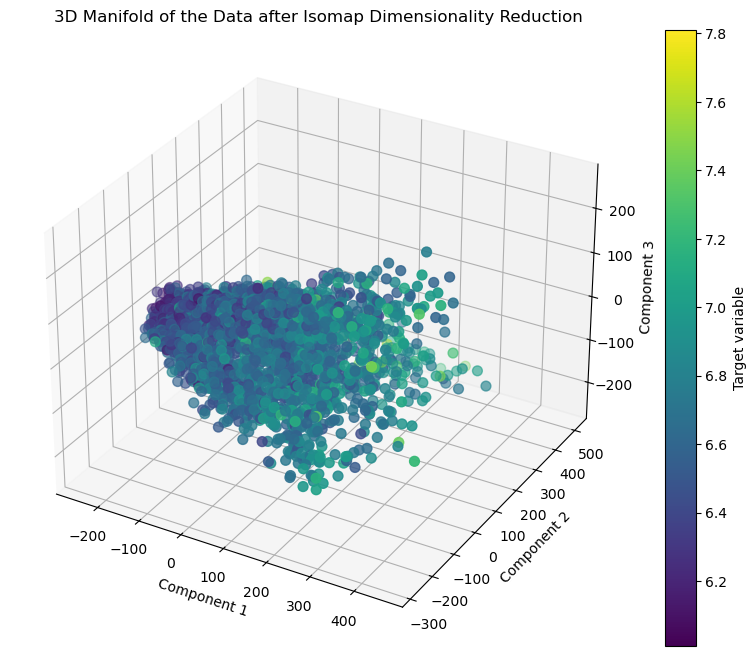

In [3]:
from sklearn.manifold import Isomap
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply Isomap for dimensionality reduction
n_neighbors = 5  # Number of neighbors for Isomap
n_components = 2  # Reduce to 2 components (you can experiment with this)

isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
X_train_reduced = isomap.fit_transform(X_train)
X_val_reduced = isomap.transform(X_val)

# Initialize the GradientBoostingRegressor model with default parameters
model = GradientBoostingRegressor(random_state=42)

# Train the model with the reduced features
model.fit(X_train_reduced, y_train)

# Predict on the validation set
y_pred = model.predict(X_val_reduced)

# Evaluate the model performance
mse = mean_squared_error(y_val, y_pred)
r2 = model.score(X_val_reduced, y_val)

# Output the results
print(f'Final Model MSE: {mse}')
print(f'Final R²: {r2}')

import matplotlib.pyplot as plt
from sklearn.manifold import Isomap
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply Isomap for dimensionality reduction
n_neighbors = 5  # Number of neighbors for Isomap
n_components = 3  # Reduce to 3 components

isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
X_train_reduced = isomap.fit_transform(X_train)

# Plotting the 3D manifold after Isomap transformation
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the data
scatter = ax.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], X_train_reduced[:, 2], c=y_train, cmap='viridis', s=50)

# Add color bar for the target variable
colorbar = fig.colorbar(scatter, ax=ax)
colorbar.set_label('Target variable')

# Labels and title
ax.set_title('3D Manifold of the Data after Isomap Dimensionality Reduction')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

plt.show()

In [4]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define the objective function for Optuna optimization
def objective(trial):
    # Hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    
    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize the RandomForestRegressor with trial parameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = model.predict(X_val)
    
    # Compute the R² score
    r2 = model.score(X_val, y_val)
    
    return r2  # We want to maximize R²

# Create an Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Output the best trial's parameters and R² score
print("Best trial:")
trial = study.best_trial
print(f"R²: {trial.value}")
print(f"Best hyperparameters: {trial.params}")


[I 2025-04-02 00:33:39,321] A new study created in memory with name: no-name-9c22e33b-604c-4ffc-ad7c-a191ddc3732d
[I 2025-04-02 00:33:39,490] Trial 0 finished with value: 0.38658989419269907 and parameters: {'n_estimators': 65, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 0 with value: 0.38658989419269907.
[I 2025-04-02 00:33:39,837] Trial 1 finished with value: 0.38850028393587366 and parameters: {'n_estimators': 163, 'max_depth': 7, 'min_samples_split': 12, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.38850028393587366.
[I 2025-04-02 00:33:39,945] Trial 2 finished with value: 0.3366498006053783 and parameters: {'n_estimators': 72, 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.38850028393587366.
[I 2025-04-02 00:33:42,058] Trial 3 finished with value: 0.4381059571390745 and parameters: {'n_estimators': 152, 'max_depth': 20,

Best trial:
R²: 0.4453849386498433
Best hyperparameters: {'n_estimators': 129, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': None}


In [5]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

Accuracy: 0.5691

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.64      0.63       237
           1       0.45      0.42      0.44       250
           2       0.62      0.65      0.64       244

    accuracy                           0.57       731
   macro avg       0.57      0.57      0.57       731
weighted avg       0.57      0.57      0.57       731



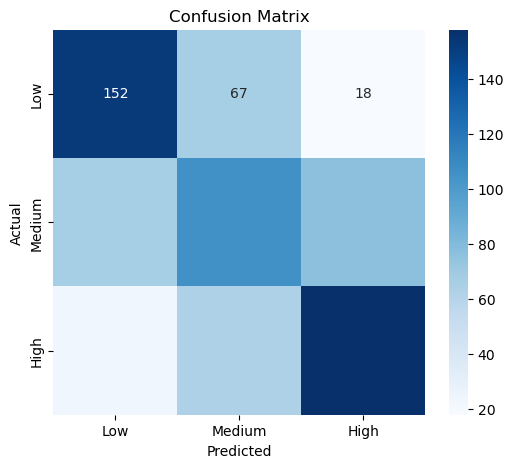

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset (assuming it's a DataFrame named df)
# df = pd.read_csv("path_to_your_data.csv")

# Feature Engineering (as defined before)
def feature_engineering(df):
    df['Defensive_Efficiency'] = (df['Tkl'] + df['Blocks'] + df['Int']) / df['90s']
    df['Offensive_Contribution'] = (df['Att 3rd'] + df['Crs'] + df['Sh']) / df['90s']
    df['Tactical_Contribution'] = df['TklW'] + (df['Tkl%'] * df['Tkl'])
    df['Penalty_Risk'] = (df['CrdY'] + df['CrdR'] + df['PKcon']) / df['90s']
    df['Defensive_Interaction'] = df['Tkl'] + df['Blocks'] + df['Int']
    #df['Seasonal_Trend'] = df.groupby('Season')['Rating'].transform(lambda x: x.diff()).fillna(0)
    df['Win_Ratio'] = df['Won'] / (df['Won'] + df['Lost'])
    return df

df = feature_engineering(df)

# Define features
features = ['Defensive_Efficiency', 'Offensive_Contribution', 'Tactical_Contribution', 
            'Penalty_Risk', 'Defensive_Interaction', 'Win_Ratio', '90s', 'Tkl', 'TklW', 
            'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Chl-Tkl', 'Att', 'Tkl%', 'Chl-Lost', 'Blocks', 'Sh', 'Pass', 'Int', 
            'Tkl+Int', 'Clr', 'Err', 'CrdY', 'CrdR', '2CrdY', 'Fls', 'Off', 'Crs', 'PKcon', 'OG', 'Recov', 'Won', 'Lost']

X = df[features]
y = df['Rating']

# Convert Rating into Categories (Low, Medium, High)
num_bins = 3  # Adjust if needed
binning = KBinsDiscretizer(n_bins=num_bins, encode='ordinal', strategy='quantile')
y_binned = binning.fit_transform(y.values.reshape(-1, 1)).astype(int)  # Convert to integer classes

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y_binned, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# XGBoost Classifier with Given Parameters
xgb_clf = XGBClassifier(
    n_estimators=700,
    max_depth=3,
    learning_rate=0.0605487138909333,
    subsample=0.6177495307302218,
    colsample_bytree=0.6524095821589513,
    reg_alpha=0.6304827381123799,
    reg_lambda=0.023966067481592194,
    min_child_weight=8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss"
)

# Train the Model
xgb_clf.fit(X_train_scaled, y_train)

# Predictions
y_pred = xgb_clf.predict(X_val_scaled)

# Evaluate Model
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["Low", "Medium", "High"], yticklabels=["Low", "Medium", "High"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Validation R²: 0.4822 | MAE: 0.1299 | RMSE: 0.1690
Test R²: 0.4557 | MAE: 0.1430 | RMSE: 0.1821


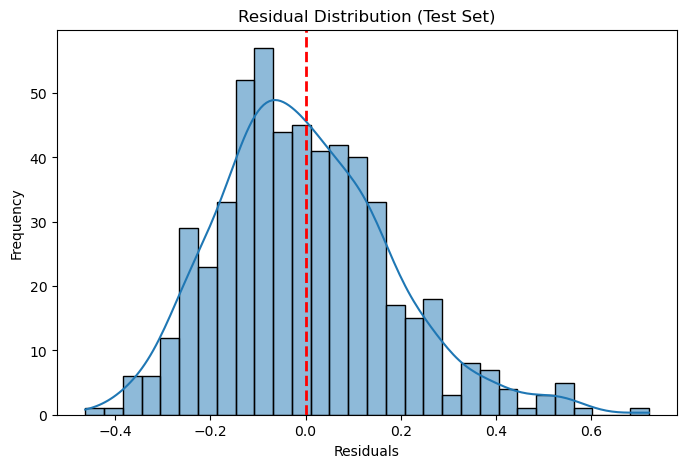

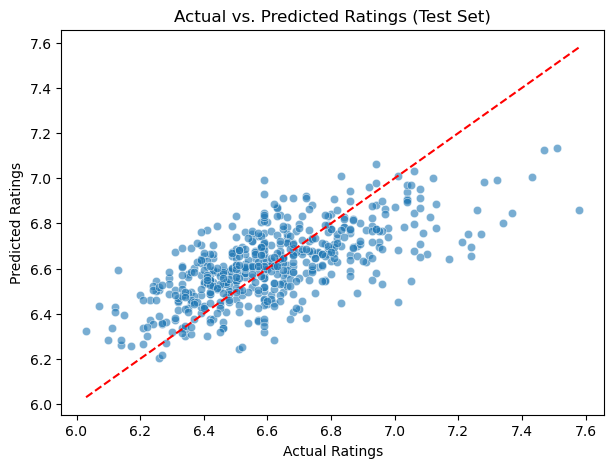

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset (assuming it's a DataFrame named df)
# df = pd.read_csv("path_to_your_data.csv")

# Feature Engineering
def feature_engineering(df):
    df['Defensive_Efficiency'] = (df['Tkl'] + df['Blocks'] + df['Int']) / df['90s']
    df['Offensive_Contribution'] = (df['Att 3rd'] + df['Crs'] + df['Sh']) / df['90s']
    df['Tactical_Contribution'] = df['TklW'] + (df['Tkl%'] * df['Tkl'])
    df['Penalty_Risk'] = (df['CrdY'] + df['CrdR'] + df['PKcon']) / df['90s']
    df['Defensive_Interaction'] = df['Tkl'] + df['Blocks'] + df['Int']
    #df['Seasonal_Trend'] = df.groupby('Season')['Rating'].transform(lambda x: x.diff()).fillna(0)
    df['Win_Ratio'] = df['Won'] / (df['Won'] + df['Lost'])
    return df

df = feature_engineering(df)

# Define features and target variable
features = ['Defensive_Efficiency', 'Offensive_Contribution', 'Tactical_Contribution', 
            'Penalty_Risk', 'Defensive_Interaction', 'Win_Ratio', '90s', 'Tkl', 'TklW', 
            'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Chl-Tkl', 'Att', 'Tkl%', 'Chl-Lost', 'Blocks', 'Sh', 'Pass', 'Int', 
            'Tkl+Int', 'Clr', 'Err', 'CrdY', 'CrdR', '2CrdY', 'Fls', 'Off', 'Crs', 'PKcon', 'OG', 'Recov', 'Won', 'Lost']

X = df[features]
y = df['Rating']

# Split into train (70%), validation (15%), test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# XGBoost Regressor with Given Parameters
xgb_reg = XGBRegressor(
    n_estimators=700,
    max_depth=3,
    learning_rate=0.0605487138909333,
    subsample=0.6177495307302218,
    colsample_bytree=0.6524095821589513,
    reg_alpha=0.6304827381123799,
    reg_lambda=0.023966067481592194,
    min_child_weight=8,
    random_state=42
)

# Train the Model
xgb_reg.fit(X_train_scaled, y_train)

# Predictions
y_val_pred = xgb_reg.predict(X_val_scaled)
y_test_pred = xgb_reg.predict(X_test_scaled)

# Evaluate Model
def evaluate_model(y_true, y_pred, dataset_name):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{dataset_name} R²: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")

evaluate_model(y_val, y_val_pred, "Validation")
evaluate_model(y_test, y_test_pred, "Test")

# Plot Residuals
residuals = y_test - y_test_pred

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(0, color='r', linestyle='dashed', linewidth=2)
plt.title("Residual Distribution (Test Set)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Scatter Plot of Predictions vs Actuals
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed')
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual vs. Predicted Ratings (Test Set)")
plt.show()


In [8]:
import optuna
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from itertools import compress

# Feature names (adjust based on your dataset)
feature_names = [
    "90s", "Tkl", "TklW", "Def 3rd", "Mid 3rd", "Att 3rd", "Chl-Tkl", "Att", "Tkl%",
    "Chl-Lost", "Blocks", "Sh", "Pass", "Int", "Tkl+Int", "Clr", "Err", "CrdY",
    "CrdR", "2CrdY", "Fls", "Off", "Crs", "PKcon", "OG", "Recov", "Won", "Lost",
    "Won%", "Season"
]

# Train/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Optuna objective function
def objective(trial):
    # Feature selection (randomly choose features)
    selected_features = [trial.suggest_categorical(f"feature_{i}", [0, 1]) for i in range(len(feature_names))]
    
    # If all features are removed, force at least one to be included
    if sum(selected_features) == 0:
        return -np.inf
    
    # Apply feature mask
    X_train_selected = X_train_scaled[:, selected_features]
    X_val_selected = X_val_scaled[:, selected_features]
    
    # Hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }
    
    # Train model
    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train_selected, y_train)
    
    # Validate model
    y_val_pred = model.predict(X_val_selected)
    
    # Return R² score
    return r2_score(y_val, y_val_pred)

# Run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get best features
best_feature_mask = [study.best_trial.params[f"feature_{i}"] for i in range(len(feature_names))]
best_features = list(compress(feature_names, best_feature_mask))

print("Best Features:", best_features)
print("Best Hyperparameters:", study.best_params)
print("Best R² Score:", study.best_value)


[I 2025-04-02 00:34:56,143] A new study created in memory with name: no-name-7dd9ce47-f99a-49c3-8e07-708f68d82283
[I 2025-04-02 00:34:57,960] Trial 0 finished with value: -0.24023650711537448 and parameters: {'feature_0': 0, 'feature_1': 0, 'feature_2': 1, 'feature_3': 0, 'feature_4': 1, 'feature_5': 1, 'feature_6': 0, 'feature_7': 1, 'feature_8': 1, 'feature_9': 1, 'feature_10': 1, 'feature_11': 0, 'feature_12': 1, 'feature_13': 1, 'feature_14': 0, 'feature_15': 1, 'feature_16': 0, 'feature_17': 0, 'feature_18': 0, 'feature_19': 1, 'feature_20': 0, 'feature_21': 1, 'feature_22': 1, 'feature_23': 0, 'feature_24': 0, 'feature_25': 1, 'feature_26': 1, 'feature_27': 1, 'feature_28': 0, 'feature_29': 0, 'n_estimators': 734, 'max_depth': 8, 'learning_rate': 0.07515410549428309, 'subsample': 0.8354465267727758, 'colsample_bytree': 0.6752115148361248, 'reg_alpha': 0.44669654158526384, 'reg_lambda': 0.9704829821700951, 'min_child_weight': 2}. Best is trial 0 with value: -0.24023650711537448.
[

Best Features: ['90s', 'Tkl', 'Def 3rd', 'Mid 3rd', 'Tkl%', 'Blocks', 'Sh', 'Int', 'Tkl+Int', 'Clr', 'CrdR', '2CrdY', 'Fls', 'PKcon', 'OG', 'Won', 'Lost']
Best Hyperparameters: {'feature_0': 1, 'feature_1': 1, 'feature_2': 0, 'feature_3': 1, 'feature_4': 1, 'feature_5': 0, 'feature_6': 0, 'feature_7': 0, 'feature_8': 1, 'feature_9': 0, 'feature_10': 1, 'feature_11': 1, 'feature_12': 0, 'feature_13': 1, 'feature_14': 1, 'feature_15': 1, 'feature_16': 0, 'feature_17': 0, 'feature_18': 1, 'feature_19': 1, 'feature_20': 1, 'feature_21': 0, 'feature_22': 0, 'feature_23': 1, 'feature_24': 1, 'feature_25': 0, 'feature_26': 1, 'feature_27': 1, 'feature_28': 0, 'feature_29': 0, 'n_estimators': 985, 'max_depth': 2, 'learning_rate': 0.01001805251631565, 'subsample': 0.7871793037393009, 'colsample_bytree': 0.937108286645858, 'reg_alpha': 0.6974104132030737, 'reg_lambda': 0.6141621685244425, 'min_child_weight': 10}
Best R² Score: 0.04834433755773493


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from itertools import permutations
import numpy as np

df.dropna(inplace=True)

# Drop non-numeric columns (assuming Player Name, Pos, Squad, League, and Season are not useful for modeling)
X = df.drop(columns=['Rating', 'Player Name', 'Squad', 'Season', 'League', 'Pos'], errors="ignore")

# Ensure 'y' is just the target column (Rating)
y = df['Rating']

# Step 1: Split the data into 5 parts
X_splits = np.array_split(X, 5)
y_splits = np.array_split(y, 5)

# Step 2: Generate all possible combinations of 3 training folds, 1 validation fold, and 1 test fold
splits = list(permutations(range(5), 3))  # Generates all combinations of 3 training folds from 5

# Store results
results = []
val_mse = []
test_mse = []

# Step 3: Perform cross-validation for each combination of splits
for train_indices in splits:
    val_test_indices = [i for i in range(5) if i not in train_indices]  # Remaining two folds
    for swap in [False, True]:  # Try both configurations
        if swap:
            val_indices, test_indices = val_test_indices[::-1]  # Swap validation and test
        else:
            val_indices, test_indices = val_test_indices  # Original order

        # Combine the training data from the selected splits
        X_train = pd.concat([X_splits[i] for i in train_indices], axis=0)
        y_train = pd.concat([y_splits[i] for i in train_indices], axis=0)

        # Validation data
        X_val = X_splits[val_indices]
        y_val = y_splits[val_indices]

        # Test data
        X_test = X_splits[test_indices]
        y_test = y_splits[test_indices]

        # Step 4: Initialize the XGBoost Regressor
        model = xgb.XGBRegressor(
            n_estimators=700,
            max_depth=3,
            learning_rate=0.0605487138909333,
            subsample=0.6177495307302218,
            colsample_bytree=0.6524095821589513,
            reg_alpha=0.6304827381123799,
            reg_lambda=0.023966067481592194,
            min_child_weight=8,
            random_state=42
        )

        # Step 5: Train the model
        model.fit(X_train, y_train)

        # Step 6: Predict on the validation fold
        y_val_pred = model.predict(X_val)
        val_r2 = r2_score(y_val, y_val_pred)

        # Step 7: Predict on the test fold
        y_test_pred = model.predict(X_test)
        test_r2 = r2_score(y_test, y_test_pred)

        # Calculate MSE for validation and test
        val_mse_fold = mean_squared_error(y_val, y_val_pred)
        test_mse_fold = mean_squared_error(y_test, y_test_pred)

        # Append MSE values
        val_mse.append(val_mse_fold)
        test_mse.append(test_mse_fold)

        # Store the results (R² values)
        results.append({
            'train_folds': train_indices,
            'val_fold': val_indices,
            'test_fold': test_indices,
            'val_r2': val_r2,
            'test_r2': test_r2,
            'val_mse': val_mse_fold,
            'test_mse': test_mse_fold,
            'swap': swap
        })

# Step 8: Summarize the results
results_df = pd.DataFrame(results)
print(results_df)

# Optionally, you can take the average of the R² and MSE across all splits
average_val_r2 = results_df['val_r2'].mean()
average_test_r2 = results_df['test_r2'].mean()
average_val_mse = results_df['val_mse'].mean()
average_test_mse = results_df['test_mse'].mean()

print(f"Average Validation R² across all splits: {average_val_r2:.4f}")
print(f"Average Test R² across all splits: {average_test_r2:.4f}")
print(f"Average Validation MSE across all splits: {average_val_mse:.4f}")
print(f"Average Test MSE across all splits: {average_test_mse:.4f}")


    train_folds  val_fold  test_fold    val_r2   test_r2   val_mse  test_mse  \
0     (0, 1, 2)         3          4  0.460693  0.517353  0.030602  0.027768   
1     (0, 1, 2)         4          3  0.517353  0.460693  0.027768  0.030602   
2     (0, 1, 3)         2          4  0.428056  0.516801  0.028947  0.027800   
3     (0, 1, 3)         4          2  0.516801  0.428056  0.027800  0.028947   
4     (0, 1, 4)         2          3  0.418459  0.447439  0.029433  0.031354   
..          ...       ...        ...       ...       ...       ...       ...   
115   (4, 3, 0)         2          1  0.447040  0.454874  0.027986  0.031737   
116   (4, 3, 1)         0          2  0.439991  0.448399  0.030889  0.027917   
117   (4, 3, 1)         2          0  0.448399  0.439991  0.027917  0.030889   
118   (4, 3, 2)         0          1  0.457210  0.446489  0.029939  0.032225   
119   (4, 3, 2)         1          0  0.446489  0.457210  0.032225  0.029939   

      swap  
0    False  
1     True  


In [10]:
from sklearn.model_selection import cross_val_score, KFold
import xgboost as xgb

kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-Fold CV

model = xgb.XGBRegressor(
    n_estimators=700,
    max_depth=3,
    learning_rate=0.0605487138909333,
    subsample=0.6177495307302218,
    colsample_bytree=0.6524095821589513,
    reg_alpha=0.6304827381123799,
    reg_lambda=0.023966067481592194,
    min_child_weight=8,
    random_state=42
)

scores = cross_val_score(model, X, y, cv=kf, scoring='r2')  # Evaluates R² score

print("Cross-validation R² scores:", scores)
print("Average R² score:", scores.mean())


Cross-validation R² scores: [0.46462531 0.49220915 0.49416985 0.39487306 0.51259854]
Average R² score: 0.47169518069536326


In [11]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import numpy as np

# Drop missing values
df.dropna(inplace=True)

# Drop non-numeric columns (assuming Player Name, Pos, Squad, League, and Season are not useful for modeling)
X = df.drop(columns=['Rating', 'Player Name', 'Squad', 'Season', 'League', 'Pos'], errors="ignore")

# Ensure 'y' is just the target column (Rating)
y = df['Rating']

# Convert data to XGBoost DMatrix
dtrain = xgb.DMatrix(X, label=y)

# Define XGBoost parameters
params = {
    "objective": "reg:squarederror",
    "max_depth": 3,
    "learning_rate": 0.0605487138909333,
    "subsample": 0.6177495307302218,
    "colsample_bytree": 0.6524095821589513,
    "reg_alpha": 0.6304827381123799,
    "reg_lambda": 0.023966067481592194,
    "min_child_weight": 8,
    "seed": 42
}

# Perform XGBoost cross-validation
cv_results = xgb.cv(params, dtrain, num_boost_round=700, nfold=5, metrics=["rmse"], early_stopping_rounds=10)

# Extract RMSE and compute MSE
average_rmse = cv_results['test-rmse-mean'].iloc[-1]
average_mse = average_rmse ** 2  # Convert RMSE to MSE

# Compute R² manually
variance_y = np.var(y)  # Total variance of target variable
average_r2 = 1 - (average_mse / variance_y)

print(cv_results)
print(f"Average R² score: {average_r2:.4f}")
print(f"Average MSE score: {average_mse:.4f}")

     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0           0.231618        0.000684        0.231901       0.002871
1           0.227336        0.000676        0.227910       0.002839
2           0.223592        0.000758        0.224424       0.002899
3           0.220034        0.000775        0.221065       0.002859
4           0.216705        0.000846        0.218092       0.002841
..               ...             ...             ...            ...
199         0.146696        0.000813        0.172474       0.003093
200         0.146615        0.000787        0.172470       0.003106
201         0.146522        0.000788        0.172499       0.003106
202         0.146420        0.000810        0.172455       0.003134
203         0.146303        0.000803        0.172432       0.003105

[204 rows x 4 columns]
Average R² score: 0.4672
Average MSE score: 0.0297


In [19]:
xgb_reg.feature_importances_

array([0.02235863, 0.02691823, 0.02597241, 0.02489739, 0.07020053,
       0.03577782, 0.07040179, 0.01411777, 0.0205178 , 0.0161348 ,
       0.02460785, 0.05781602, 0.0170256 , 0.01366186, 0.01818214,
       0.01628278, 0.0140769 , 0.01546628, 0.01618051, 0.02199629,
       0.07628692, 0.02233893, 0.01596824, 0.0144537 , 0.02721922,
       0.01837425, 0.01726193, 0.02814741, 0.03807648, 0.02447182,
       0.01734085, 0.10803904, 0.03241578, 0.01701199], dtype=float32)